# Моделирование трафика с помощью MAP-потоков

В этом ноутбуке представлен эксперимент по аппроксимации трафика, передаваемого сетью, с помощью MAP-потока.

Во всех экспериментах с многошаговыми сетями используется два типа входящего трафика:

- простейшие потоки Пуассона
- MAP-потоки с ненулевой корреляцией

Размеры пакетов имеют ограничения, обусловленные значениями MTU (Maximum Transmission Unit), поэтому для вариации скорости трафика изменяться будут не размеры пакетов, а средние значения интервалов между ними.

Например, если пакеты имеют размер 10'000 бит, и нужно получить трафик 10 кбит/с, то интервалы между пакетами будут в среднем равны 1 секунде, а если нужен трафик 500 кбит/с, то 0.02 секунды.

Для пуассоновских потоков, характеризуемых только средним временем между поступлениями пакетов, этого достаточно. Что касается MAP-потоков порядка выше единицы, для них также будем менять среднее значение, сохраняя их структуру, то есть будем просто их масштабировать. Пусть MAP-поток $\xi_1 \sim MAP(D_0, D_1)$, и пусть 
$$
    \mathbb{E}\xi_1 = \overline{\alpha} (-D_0)^{-1} \overline{1} = 1,
$$
где $\overline{\alpha}$ - стационарное распределение вероятностей вложенной цепи с матрицей переходов $P = (-D_0)^{-1} D_1$. 

Определим новый поток $\xi_{m} = MAP(D'_0, D'_1)$, где $D'_i = \frac{1}{m} D_i,\; i = 0,1$. Для него:
$$
    \begin{aligned}
        &P' = (-D'_0)^{-1} D'_1 = (\frac{1}{m} (-D_0))^{-1} (\frac{1}{m} D_1) = \frac{m}{m} (-D_0)^{-1} D_1 = P\\
        &\mathbb{E}\xi_m = \overline{\alpha} (-D'_0)^{-1} \overline{1} = \overline{\alpha} (m(-D_0)^{-1}) \overline{1} = m \mathbb{E}\xi_1
    \end{aligned}
$$

Таким образом, получив MAP-поток $\xi_1 = MAP(D_0, D_1)$ для некоторой выборки интервалов со средним значением 1, мы будем использовать MAP-потоки $\xi_m = MAP(\frac{1}{m}D_0, \frac{1}{m}D_1)$, когда нам будем нужен MAP-поток со средним значением интервалов, равным $m$.

Для получения выборки интервалов будет использоваться записанный дамп Wireshark, полученный при стриминге программой VLC через локальную сеть WiFi по протоколу RTP 8-минутного фрагмента фильма 1929 года "Андалузский Пес" (реж. Луис Бунюэль, сценарий Сальвадор Дали и Луис Бунюэль, доступен на archive.org: https://archive.org/download/UnChienAndalou_313). Выборка сначала извлекается из дампа, а затем нормализируется.

## 1. Подготовка ноутбука

Сначала настроим ноутбук и подключим все необходимые пакеты.

In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
import time
import numpy as np
import pandas as pd
import array_to_latex as a2l

# Эти библиотеки понадобятся для разбора дампов Wireshark:
from scapy.utils import RawPcapReader
from scapy.layers.l2 import Ether

In [3]:
# Подключаем локальные пакеты (из диссертационного проекта)
from pyqumo import stats
from pyqumo.fitting import fit_map
from pyqumo.arrivals import MAP

In [4]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

Определим переменные окружения, которые будут использоваться в эксперименте.

In [48]:
DUMP_FILE_NAME = 'video_03.pcapng'                   # имя файла с дампом
DUMP_FILE_DIR = os.path.join('..', 'data', 'dumps')  # предполагаем, что дампы лежат в папке ../data/dumps

MIN_MAP_ORDER = 2   # минимальный порядок искомых MAP-потоков
MAX_MAP_ORDER = 4   # максимальный порядок искомых MAP-потоков

# Нужно ли пересчитывать все, или можно использовать результаты из файлов
FORCE_COMPUTE = True
MAP_FILE_NAME = 'traffic.csv'
MAP_FILE_DIR = os.path.join('..', 'data', 'networks')

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

In [49]:
def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)

## 2. Анализ дампа

Первым делом извлечем данные о пакетах из дампа. Нас будут интересовать времена поступления и размеры пакетов. В результате выполнения следующего кода будут записаны:

- `dump_data`: список данных о пакетах из дампа
- `timestamps`: вектор NumPy с моментами поступления пакетов
- `raw_intervals`: вектор NumPy с интервалами между пакетами

In [50]:
# Определим именованный кортеж, который будет использоваться для описания пакета.
# Нас будет интересовать время поступления и размер пакета.
Packet = namedtuple('Packet', ('id', 'timestamp', 'bitlen'))

def parse_pcap(file_name):
    """Функция извлекает данные о пакетах из дампа Wireshark. 
    """
    return [
        Packet(id=i+1, timestamp=Ether(pkt).time, bitlen=metadata.wirelen*8) 
        for i, (pkt, metadata) in enumerate(RawPcapReader(file_name))]

dump_data = parse_pcap(os.path.join(DUMP_FILE_DIR, DUMP_FILE_NAME))
timestamps = np.asarray([record.timestamp for record in dump_data])
raw_intervals = timestamps[1:] - timestamps[:-1]

Убедимся, что все пакеты имеют практически идентичный размер и выведем его.

In [51]:
packet_sizes = np.asarray([pkt.bitlen for pkt in dump_data])
mean_packet_size = packet_sizes.mean()
print(f"Размер первого пакета, бит: {dump_data[0].bitlen}")
print(f"Средний размер пакета, бит: {mean_packet_size:.1f}")
print("Коэффициент вариации: {:.2f}".format(packet_sizes.std() / mean_packet_size))

Размер первого пакета, бит: 10960
Средний размер пакета, бит: 10934.3
Коэффициент вариации: 0.05


Отобразим статистику по поступлениям пакетов из источника.

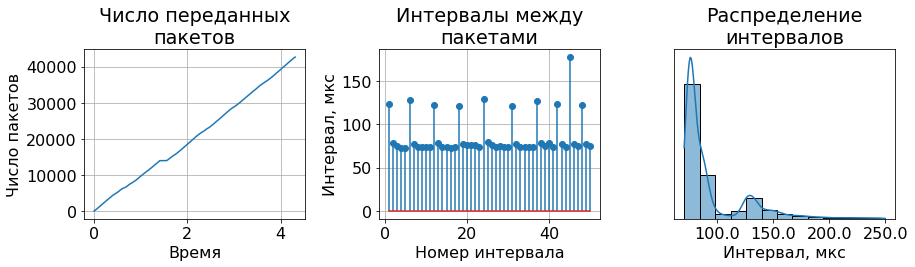

In [52]:
import seaborn

def display_arrivals_shape(intervals, limit=-1):
    """Отображает график зависимости числа пакетов от времени и фрагмент выборки интервалов."""
    fig, (ax_t, ax_i, ax_h) = plt.subplots(figsize=(13, 4), nrows=1, ncols=3)
    
    # Изобразим число пакетов на левом графике:
    num_packets = np.arange(1, len(intervals)+1)
    all_moments = np.cumsum(intervals)
    ax_t.plot(all_moments, num_packets)
    ax_t.set_title('Число переданных\nпакетов')
    ax_t.set_xlabel('Время')
    ax_t.set_ylabel('Число пакетов')
    ax_t.grid()
    
    # Изобразим несколько интервалов:
    fragment = np.asarray(intervals[1000:1000+limit])
    num_fragment_packets = np.arange(1, len(fragment)+1)    
    ax_i.stem(num_fragment_packets, fragment, use_line_collection=True)
    ax_i.set_title('Интервалы между\nпакетами')
    ax_i.set_xlabel('Номер интервала')
    ax_i.set_ylabel('Интервал, мкс')
    ax_i.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,n: f'{x*1e6:g}'))
    ax_i.grid()
    
    # Гисотграмма. При ее изображении отфильтруем интервалы, большие 0.00025
    filtered_intervals = [x for x in intervals if x < 0.00025]
    seaborn.histplot(filtered_intervals, kde=True, ax=ax_h, bins=13)
    ax_h.set_xlabel('Интервал, мкс')
    ax_h.set_ylabel('')
    ax_h.set_title('Распределение\nинтервалов')
    ax_h.set_yticks(())
    ax_h.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,n: x * 1e6))

    return fig, (ax_t, ax_i, ax_h)

fig, _ = display_arrivals_shape(raw_intervals, 50)
plt.tight_layout()

Вычислим статистические хараеткристики трафика - среднее значение, коэффициент вариации и первые лаги. Кроме того, отфильтруем слишком большие значения интервалов (более 300 мкс) и сравним статистические характеристики исходной выборки и отфильтрованной.

In [53]:
Stats = namedtuple('Stats', ('mean', 'std', 'cv', 'rate', 'moments', 'lags'))

def get_samples_stats(samples, num_moments=6, num_lags=6):
    """
    Вычисляет статистические оценки выборки.
    """
    moments = stats.moment(samples, max(num_moments, 2))
    std = np.sqrt(moments[1] - moments[0] ** 2)
    return Stats(
        mean=moments[0],
        std=std,
        cv=std/moments[0],
        rate=1/moments[0],
        moments=moments[:num_moments],
        lags=stats.lag(samples, num_lags)
    )

# Вычисляем характеристики исходной выборки интервалов:
raw_stats = get_samples_stats(raw_intervals, num_moments=6, num_lags=7)

# Отфильтруем выборку и вычислим характеристики отфильтрованной выборки:
filtered_intervals = np.asarray([x for x in raw_intervals if x < 3e-4])
filtered_raw_stats = get_samples_stats(filtered_intervals, num_moments=6, num_lags=7)

# Выведем данные по фильтрации:
table_ = [
    ('Raw samples size', len(raw_intervals)),
    ('Filtered samples size', len(filtered_intervals)),
    ('Dropped samples', len(raw_intervals) - len(filtered_intervals)),
    ('% of filtered samples', (len(raw_intervals) - len(filtered_intervals)) / len(raw_intervals) * 100),
]
print(tabulate(table_))

---------------------  ------------
Raw samples size       42630
Filtered samples size  42400
Dropped samples          230
% of filtered samples      0.539526
---------------------  ------------


Если теперь посмотреть на статистические характеристики отфильтрованных интервалов, то можно увидеть, что все старшие моменты отличаются в два и более раза у фильтрованной и исходной выборок. Особенно примечательно, что коэффициент вариации исходной выборки - больше единицы, а отфильтрованной - меньше единицы. Это очень важное отличие, так как оно определяет форму MAP-потока или PH-распределения.

In [54]:
def print_samples_stats(stats_, titles=(), max_moments=6, max_lags=6):
    """
    Выводит таблицу со статистическими данными выборки.
    """
    # Если передали только одну структуру `Stats`, то
    # обернем ее в список:
    if isinstance(stats_, Stats):
        stats_ = [stats_]

    # Построим таблицу с данными:
    data = [
        ['Mean'] + [s.mean for s in stats_],
        ['Std.'] + [s.std for s in stats_],
        ['CV'] + [s.cv for s in stats_],
        ['Rate'] + [s.rate for s in stats_],
    ]

    # Добавляем данные о моментах:
    num_moments = min(max_moments, min([len(s.moments) for s in stats_]))
    for i in range(1, num_moments):
        data.append([f'{i+1}-th moment ({i+1}-th root of)'] + [s.moments[i]**(1/(i+1)) for s in stats_])
    
    # Добавляем данные о корреляции:
    num_lags = min(max_lags, min([len(s.lags) for s in stats_]))
    for i in range(num_lags):
        data.append([f'Lag-{i+1}'] + [s.lags[i] for s in stats_])
        
    # Формируем заголовок
    if not titles:
        titles = ['Value']
    headers = ['Parameter'] + list(titles)
    
    # Если было подано две колонки, то добавим колонку с ошибками (первой относительно второй):
    if len(stats_) == 2:
        data = [row + [int(np.ceil(abs(row[2] - row[1]) / row[2] * 100))] for row in data]
        headers += ['Error, %']
    
    # Печатаем таблицу
    print(tabulate(data, headers=headers, tablefmt='github', floatfmt='.6f', numalign="right"))

# Печатаем характеристики исходной выборки интервалов:
print_samples_stats(
    [raw_stats, filtered_raw_stats], 
    titles=['Raw', 'Filtered'], 
    max_moments=6, 
    max_lags=7
)

| Parameter                  |         Raw |     Filtered |   Error, % |
|----------------------------|-------------|--------------|------------|
| Mean                       |    0.000101 |     0.000096 |          6 |
| Std.                       |    0.000702 |     0.000034 |       1973 |
| CV                         |    6.944706 |     0.352035 |       1873 |
| Rate                       | 9893.427850 | 10392.459489 |          5 |
| 2-th moment (2-th root of) |    0.000709 |     0.000102 |        596 |
| 3-th moment (3-th root of) |    0.004145 |     0.000110 |       3684 |
| 4-th moment (4-th root of) |    0.010077 |     0.000119 |       8399 |
| 5-th moment (5-th root of) |    0.017171 |     0.000128 |      13268 |
| 6-th moment (6-th root of) |    0.024498 |     0.000138 |      17593 |
| Lag-1                      |    0.003245 |     0.181232 |         99 |
| Lag-2                      |    0.000657 |     0.097273 |        100 |
| Lag-3                      |    0.000308 |     0.

Из полученных данных можно отметить два момента. Во-первых, коэффициент вариации меньше 1, то есть такой трафик плохо приближать пуассоновским потоком (для него коэффициент вариации всегда равен единице). Во-вторых, есть существенная автокорреляция между соседними значениями выборки $X_t$ и $X_{t+1}$, но даже большая - между $X_t$ и $X_{t+6}$. К сожалению, для качественного учета автокорреляции высокий порядков требуется использовать MAP-потоки большой размерности. Поэтому в дальнейшем сосредоточимся на автокорреляции с лагом 1. Еще отметим, что автокорреляция с лагами 2, 3 и 4 очень маленькая.

## 3. Построение MAP-потока

Для построения MAP-потока нужно сначала нормализовать выборку. Затем построим несколько MAP-потоков, используя EM-алгоритм и метод моментов, и сравним степень близости к выборке. Наилучший MAP-поток сохраним для дальнейшего использования в исследовании многошаговых сетей.

### 3.1. Нормализация выборки

В первую очередь нормализуем выборку интервалов. Для этого найдем среднее и поделим каждый интервал на это число. В результате выполнения нормализации значения коэффициентов автокорреляции не должно измениться. Для удобства, выведем статистику.

In [55]:
def normalize_samples(samples):
    """Возвращает новую выборку, у которой среднее значение равно единице.
    """
    samples = np.asarray(samples)
    mean = samples.mean()
    return samples / mean

norm_intervals = normalize_samples(filtered_intervals)
norm_stats = get_samples_stats(norm_intervals, num_lags=7)
print_samples_stats(norm_stats, max_moments=6, max_lags=7)

| Parameter                  |    Value |
|----------------------------|----------|
| Mean                       | 1.000000 |
| Std.                       | 0.352035 |
| CV                         | 0.352035 |
| Rate                       | 1.000000 |
| 2-th moment (2-th root of) | 1.060155 |
| 3-th moment (3-th root of) | 1.138398 |
| 4-th moment (4-th root of) | 1.232256 |
| 5-th moment (5-th root of) | 1.335014 |
| 6-th moment (6-th root of) | 1.439000 |
| Lag-1                      | 0.181232 |
| Lag-2                      | 0.097273 |
| Lag-3                      | 0.064120 |
| Lag-4                      | 0.066068 |
| Lag-5                      | 0.164871 |
| Lag-6                      | 0.484242 |
| Lag-7                      | 0.065612 |


### 3.2. Загрузка и выгрузка MAP-потоков из файла

Результаты предыдущих запусков эксперимента сохраняются в csv-файле `MAP_FILE_NAME` в папке `MAP_FILE_DIR` (по умолчанию, `../data/networks/traffic.csv`). Файл имеет следующую структуру:

```
+--------+-------+------+-----+-----+----------+---------+--------+---------+---------+
| Method | Order | Dump | D0  | D1  | Ellapsed | MeanErr | StdErr | Lag1Err | Lag2Err |
+--------+-------+------+-----+-----+----------+---------+--------+---------+---------+
```

- `Method`: метод, с помощью которого был получен MAP-поток, возможные значения - `'opt'`, `'em'`, `'indi'`
- `Order`: порядок MAP-потока
- `Dump`: имя файла дампа, из которого был получен MAP-поток
- `D0`, `D1`: сериализованные с помощью `json.dumps()` матрицы MAP-потока
- `Ellapsed`: время, которое требовалось для получения результатов
- `MeanErr`: относительная погрешность в оценке среднего значения
- `StdErr`: относительная погрешность в оценке стандартного отклонения
- `Lag1Err`: относительная погрешность в оценке корреляции с лагом 1
- `Lag2Err`: относительная погрешность в оценке корреляции с лагом 2

Для работы с файлом используются две функции:

- `save_maps(df: pandas.DataFrame)`
- `load_maps() -> pandas.DataFrame`

In [56]:
def save_maps(df: pd.DataFrame):
    """
    Сохранить в файл данные о MAP-потоках.
    """
    if not os.path.exists(MAP_FILE_DIR):
        os.makedirs(MAP_FILE_DIR)
    filename = os.path.join(MAP_FILE_DIR, MAP_FILE_NAME)
    df.to_csv(filename, index_label='Id')

    
def load_maps() -> pd.DataFrame:
    """
    Загрузить данные о MAP-потоках из файла. Если файла нет,
    возвращает пустую таблицу с колонками.
    """
    # Сначала определим вспомогательную функцию, которая разбирает строку
    # в массив numpy.ndarray
    def parse_numpy_array(s: str) -> np.ndarray:
        """
        Разбирает двумерный массив из того формата, в котором Pandas
        сохраняет ячейку с ndarray, то есть '[[1 2]\n [3 4]]'
        """
        s = s.replace('\n', '').replace('[', '').replace(']', '')
        a = np.fromstring(s, sep=' ')  # вектор, содержащий N^2 элементов
        n = int(len(a)**0.5)
        return a.reshape((n, n))
        
    filename = os.path.join(MAP_FILE_DIR, MAP_FILE_NAME)
    if os.path.exists(filename):
        return pd.read_csv(filename, converters={
            'D0': parse_numpy_array,
            'D1': parse_numpy_array,
        }, index_col='Id')
    return pd.DataFrame(columns=('Method', 'Order', 'Dump', 'D0', 'D1', 'Ellapsed', 'MeanErr', 'StdErr', 
                                 'M3Err', 'M4Err', 'M5Err', 'M6Err',
                                 'Lag1Err', 'Lag2Err', 'Lag3Err', 'Lag4Err', 'Lag5Err', 'Lag6Err'))

maps_df = load_maps()
maps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Method    18 non-null     object 
 1   Order     18 non-null     float64
 2   Dump      18 non-null     object 
 3   D0        18 non-null     object 
 4   D1        18 non-null     object 
 5   Ellapsed  18 non-null     float64
 6   MeanErr   18 non-null     float64
 7   StdErr    18 non-null     float64
 8   M3Err     18 non-null     float64
 9   M4Err     18 non-null     float64
 10  M5Err     18 non-null     float64
 11  M6Err     18 non-null     float64
 12  Lag1Err   18 non-null     float64
 13  Lag2Err   0 non-null      float64
 14  Lag3Err   0 non-null      float64
 15  Lag4Err   0 non-null      float64
 16  Lag5Err   0 non-null      float64
 17  Lag6Err   0 non-null      float64
 18  Lag7Err   18 non-null     float64
dtypes: float64(15), object(4)
memory usage: 2.8+ KB


### 3.3. Поиск MAP-потоков

Будем искать MAP-потоки с помощью трех методов: метода моментов (то есть решая задачу нелинейной оптимизации), с помощью EM-процедуры и с помощью независимого поиска PH-распределения и матрицы D1 по лагу. Порядки искомых потоков меняются от `MIN_MAP_ORDER` до `MAX_MAP_ORDER`.

По ходу вычислений, нам также потребуется оценивать ошибки в характеристиках найденных потоков. Определим для этого вспомогательную функцию `rel_err(x, y)`, которая возвращает относительную ошибку `abs(x - y)/x`, если `abs(x) > 1e-12`, и `abs(x-y)/(1+abs(x))` в противном случае.

In [57]:
def rel_err(x: float, y: float) -> float:
    """
    Функция вычисляет ошибку y относительно x, то есть x - верное значение.
    """
    a_x = abs(x)
    d = abs(x - y)
    if a_x > 1e-9:
        return d / a_x
    return d / (1 + a_x)

Если `FORCE_COMPUTE = False` и результат уже содержится в файле `MAP_FILE_NAME`, то он заново не рассчитывается. В противном случае рассчитываем результат и записываем его в `DataFrame`.

In [42]:
orders = tuple(range(MIN_MAP_ORDER, MAX_MAP_ORDER+1))
methods = ('opt', 'em', 'indi')

for order, method in tqdm(tuple(product(orders, methods))):
    # Реализация EM-алгориитма из BuTools (https://github.com/ghorvath78/butools), которая используется здесь,
    # странно себя ведет при более-менее больших порядках MAP: требует очень много времени и на некоторых порядках
    # распределений Эрланга (в виде которых ищется MAP) вылетает с ошибкой.
    # По этой причине, при порядке свыше 4 не рассматриваем (эти эффекты наблюдаются уже на порядке 4)
    if order > 5 and method == 'em':
        continue
        
    # Ищем MAP-поток среди восстановленных ранее. Если не найден или FORCE_COMPUTE = True, то
    # запускаем аппроксимацию с текущим методов и порядком.
    row = maps_df.loc[
        (maps_df.Method == method) & 
        (maps_df.Order == order) & 
        (maps_df.Dump == DUMP_FILE_NAME)
    ]
    not_found = row.shape[0] == 0
    if not_found or FORCE_COMPUTE:
        t0 = time.time()
        num_lags = 3 if order > 2 else 1
        num_moments = 6 if order > 2 else 3
        flow = fit_map(
            norm_intervals, order=order, method=method, 
            options={'numLags': num_lags, 'numMoments': num_moments, 'stopCond': 1e-6, 'maxIter': 100,
                     'phFitMethod': 'opt'
                    })
        data = {
            'Method': pd.Series([method], dtype='str'),
            'Order': pd.Series([order], dtype='int'),
            'Dump': pd.Series([DUMP_FILE_NAME], dtype='str'),
            'D0': pd.Series([flow.D0], dtype='object'),
            'D1': pd.Series([flow.D1], dtype='object'),
            'Ellapsed': pd.Series([time.time() - t0], dtype='float64'),
            'MeanErr': pd.Series([rel_err(norm_stats.mean, flow.mean())], dtype='float64'),
            'StdErr': pd.Series([rel_err(norm_stats.std, flow.std())], dtype='float64'),
        }
        data.update({
            f'M{i}Err': pd.Series([
                rel_err(norm_stats.moments[i-1]**(1/i), flow.moment(i)**(1/i))
            ], dtype='float64')
            for i in range(3, 7)
        })
        data.update({
            f'Lag{i}Err': pd.Series([
                rel_err(norm_stats.lags[i-1], flow.lag(i))
            ], dtype='float64')
            for i in (1, 7)
        })
        if not_found:
            maps_df = maps_df.append(pd.DataFrame(data), ignore_index=True)
        else:
            row_index = row.index[0]
            maps_df.update(pd.DataFrame(data, index=[row_index]))

# Сохраняем результат
save_maps(maps_df)

ValueError: probabilities are not non-negative

In [43]:
maps_df

,Method,Order,Dump,D0,D1,Ellapsed,MeanErr,StdErr,M3Err,M4Err,M5Err,M6Err,Lag1Err,Lag2Err,Lag3Err,Lag4Err,Lag5Err,Lag6Err,Lag7Err
Id,,,,,,,,,,,,,,,,,,,
0,opt,2.0,video_03.pcapng,"[[-2.471311672088858, 8.011311164345723e-12], ...","[[1.6808519448161e-10, 2.4713116719127615], [1...",0.397053,1.906946e-01,0.642749,0.027217,0.088626,0.130389,1.626683e-01,9.999998e-01,NaN,NaN,NaN,NaN,NaN,1.000000
1,em,2.0,video_03.pcapng,"[[-0.98838702, 0.0], [0.0, -1.01241236]]","[[0.50543936, 0.48294765], [0.51619123, 0.4962...",6.891219,3.067031e-09,0.551793,0.860716,0.930193,0.951780,9.611563e-01,9.999486e-01,NaN,NaN,NaN,NaN,NaN,1.000000
2,indi,2.0,video_03.pcapng,"[[-0.98838795, 0.0], [0.0, -1.01241165]]","[[0.98843051, 0.0], [5.14126674e-06, 1.01244531]]",0.168615,1.174847e-02,0.546593,0.859100,0.929388,0.951227,9.607140e-01,9.898568e-01,NaN,NaN,NaN,NaN,NaN,0.685253
3,opt,3.0,video_03.pcapng,"[[-0.573836567, 0.0300683978, 0.239436631], [0...","[[0.0524135542, 0.000621968141, 0.251296016], ...",15.036852,1.577724e+00,1.150675,0.225065,0.046769,0.000017,1.191236e-09,7.094488e-01,NaN,NaN,NaN,NaN,NaN,0.999999
4,em,3.0,video_03.pcapng,"[[-0.0063397, 0.0, 0.0], [0.0, -2.02301472, 2....","[[1.92864844e-08, 0.00633967737, 0.0], [0.0, 0...",34.892864,2.574711e-07,0.095060,0.083174,0.016110,0.130309,2.509276e-01,1.007164e+00,NaN,NaN,NaN,NaN,NaN,1.000000
5,indi,3.0,video_03.pcapng,"[[-0.00633998, 0.0, 0.0], [0.0, -2.02301474, 2...","[[6.20027036e-05, 0.0062779758, 0.0], [0.0, 0....",0.337303,3.790301e-13,0.095086,0.083208,0.016070,0.130264,2.508768e-01,1.089833e-12,NaN,NaN,NaN,NaN,NaN,1.000000
6,opt,4.0,video_03.pcapng,"[[-0.824237066, 5.88792268e-05, 0.0145626031, ...","[[0.580002457, 1.17491281e-06, 0.00093000164, ...",36.996125,1.521869e+00,3.279898,0.841865,0.287591,0.086389,1.859287e-05,1.075422e+00,NaN,NaN,NaN,NaN,NaN,1.000000
7,em,4.0,video_03.pcapng,"[[-0.00846905, 0.0, 0.0, 0.0], [0.0, -3.034971...","[[2.88079262e-06, 0.00846617334, 0.0, 0.0], [0...",91.352649,2.566620e-07,0.217754,0.240241,0.179204,0.100752,1.484089e-02,9.747833e-01,NaN,NaN,NaN,NaN,NaN,1.000000
8,indi,4.0,video_03.pcapng,"[[-0.00846449, 0.0, 0.0, 0.0], [0.0, -3.034971...","[[8.19728556e-05, 0.00838252083, 0.0, 0.0], [0...",0.427555,1.082689e-12,0.217579,0.239979,0.178880,0.100371,1.440525e-02,8.701048e-11,NaN,NaN,NaN,NaN,NaN,1.000000


Для удобства, представим часть этой таблицы в виде LaTeX, чтобы ее можно было вставить в текст. В это представление включим только данные о методе, порядке, времени и ошибках.

In [44]:
def print_latex_map_table(df: pd.DataFrame) -> str:
    df = df.loc[df.Dump == DUMP_FILE_NAME]
    
    method_labels = {
        'opt': 'Решение задачи оптимизации',
        'em': 'EM-алгоритм',
        'indi': 'Независимая аппроксимация моментов и лагов',
    }
    
    def get_table_row(row) -> tuple:
        return (
            method_labels[row.Method], 
            row.Order,
            f'{row.Ellapsed:.1f}',
            f'{row.MeanErr:.3f}', 
            f'{row.StdErr:.3f}', 
            f'{row.Lag1Err:.3f}', 
            f'{row.Lag2Err:.3f}',
        )
    
    rows = map(get_table_row, df.itertuples())
    table = tabulate(
        rows, 
        headers=(
            'Метод', 
            'Порядок',
            'Время',
            '$\epsilon_m$', 
            '$\epsilon_\sigma$',
            '$\epsilon_{l_1}$',
            '$\epsilon_{l_2}$'
        ),
        tablefmt='latex_raw'
    )
    print(table)

print_latex_map_table(maps_df)

\begin{tabular}{lrrrrrr}
\hline
 Метод                                      &   Порядок &   Время &   $\epsilon_m$ &   $\epsilon_\sigma$ &   $\epsilon_{l_1}$ &   $\epsilon_{l_2}$ \\
\hline
 Решение задачи оптимизации                 &         2 &     0.4 &          0.191 &               0.643 &              1     &                nan \\
 EM-алгоритм                                &         2 &     6.9 &          0     &               0.552 &              1     &                nan \\
 Независимая аппроксимация моментов и лагов &         2 &     0.2 &          0.012 &               0.547 &              0.99  &                nan \\
 Решение задачи оптимизации                 &         3 &    15   &          1.578 &               1.151 &              0.709 &                nan \\
 EM-алгоритм                                &         3 &    34.9 &          0     &               0.095 &              1.007 &                nan \\
 Независимая аппроксимация моментов и лагов &         3 &    

### 3.4. Выбор наилучших MAP-потоков

Никакие MAP-потоки, к сожалению, очень близки не подходят к распределению. Отметим, что хуже всего обстоит дело с автокорреляцией с лагом 2 и выше. Причем увеличение порядка MAP-потоков не ведет к существенному улучшению ситуации. Все алгоритмы аппроксимации содержат в себе элемент случайности, поэтому повторные запуски не всегда позволяют улучшить результаты.

Также отметим, что в EM-процедуре, реализация которой взята из пакета BuTools (https://github.com/ghorvath78/butools), на размерностях выше трех, часто возникали ошибки, и ее выполнение требовало очень много времени.

При выборе лучшего MAP-потока будем руководствоваться двумя соображениями. Во-первых, чем меньше ошибка, тем лучше, причем ошибки в оценке среднего или стандартного отклонения более приоритетны, чем ошибки в оценке коэффициентов автокорреляции высоких порядков. Во-вторых, чем меньше размерность MAP-потока, тем лучше - так будет проще генерировать его выборку в методе Монте-Карло. Для оценки MAP-потока введем следующую функцию:

$$
    F_L(\xi) = \left(\sqrt{
        \frac{
            w_n (n / N)^2 + w_m \epsilon_m^2 + w_\sigma \epsilon_\sigma^2 + 
                w_{l_1} \epsilon_{l_1}^2 + w_{l_2} \epsilon_{l_2}^2
        }{
            w_n + w_m + w_\sigma + w_{l_1} + w_{l_2}}
        }\right)^{-1},
$$
где $n$ - порядок MAP-потока, $N$ - константа, равная маскимальному порядку MAP-потоков, $\epsilon_m$ - ошибка в оценке среднего, $\epsilon_\sigma$ - ошибка в оценке стандартного отклонения, $\epsilon_{l_k}$ - ошибка в оценке автокорреляции с лагом $k$, а $w_n$, $w_m$, $w_\sigma$, $w_{l_k}$ - веса соответствующих характеристик. Самая главная характеристика - близость среднего значения, поэтому ее вес - наибольший:

$$
    w_n = 4,\;w_m = 12,\;w_{\sigma} = w_{l_1} = 5,\;w_{l_2} = 1.
$$

Также будем оценивать отклонения характеристик потока от основных статистических оценок выборки без учета порядка MAP-потока:

$$
    F_E(\xi) = \sqrt{\frac{\epsilon_m^2 + \epsilon_\sigma^2 + \epsilon_{l_1}^2}{3}}
$$

In [45]:
# Веса различных колонок, которые используются при подсчете степени близости
ApproxErrorWeight = namedtuple('ApproxErrorWeight', ('Order', 'MeanErr', 'StdErr', 'Lag1Err', 'Lag2Err',
                                                     'M3Err', 'M4Err', 'M5Err', 'M6Err'))

# Функция для расчета степени близости
def approx_likeness(row, w: ApproxErrorWeight, max_order: int = 8) -> float:
    """
    Рассчитать степень близости: чем меньше порядок и ошибки, тем лучше.
    """
    return ((
        w.Order * (row.Order / max_order)**2 +
        w.MeanErr * row.MeanErr**2 + 
        w.StdErr * row.StdErr**2 +
#         w.Lag1Err * row.Lag1Err**2 +
#         w.Lag2Err * row.Lag2Err**2
        w.M3Err * row.M3Err**2 +
        w.M4Err * row.M4Err**2 +
        w.M5Err * row.M5Err**2 +
        w.M6Err * row.M6Err**2
    ) / (
        w.Order + w.MeanErr + w.StdErr + w.Lag1Err + w.Lag2Err
    ))**-0.5


def approx_error(row) -> float:
    """
    Рассчитать величину ошибки как среднеквадратичное по ошибке в оценке среднего, отклонения и лаг-1.
    """
    return ((
        row.MeanErr**2 + 
        row.StdErr**2 + 
#         row.Lag1Err**2 +
        row.M3Err**2 +
        row.M4Err**2 +
        row.M5Err**2 +
        row.M6Err**2
    ) / 6)**0.5


# Веса, которые будем использовать по-умолчанию
APPROX_ERROR_WEIGHT = ApproxErrorWeight(1, 12, 5, 0, 0, 4, 4, 4, 4)

Для каждого MAP-потока запишем в колонку `Likeness` результат вычисления функции близости $F_L$, а в колонку `Error` - результат вычисления функции $F_E$.

In [46]:
# Применим оценки к таблице с MAP-потоками
maps_df['Likeness'] = maps_df.apply(lambda row: approx_likeness(row, APPROX_ERROR_WEIGHT), axis=1)
maps_df['Error'] = maps_df.apply(approx_error, axis=1)

Теперь изобразим на графике функции близости ($F_L$) и ошибки ($F_E$). Они должны вести себя почти одинаково. Фактически, функция ошибки позволяет подтвердить, что мы правильно выбрали веса, и наилучшим MAP-потоком будет не просто поток меньшего порядка, но и тот, у которого одна из самых низких ошибок относительно исходной выборки.

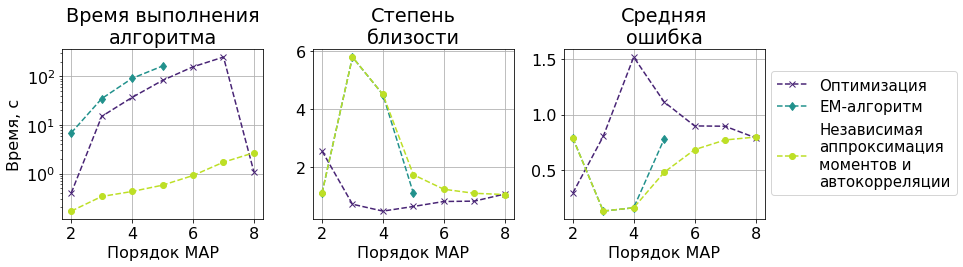

In [47]:
def plot_approx_info(df: pd.DataFrame):
    """
    Изобразить три графика: время, затраченное на выполнение алгоритма, степень близости и
    среднюю ошибку аппроксимаций.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(11, 4), nrows=1, ncols=3)

    # На каждом из трех графиков будет по три линии. Определим для них общие стили:
    lines = (
        dict(x='Order', marker='x', linestyle='--', color=get_color(0.1), legend=False),
        dict(x='Order', marker='d', linestyle='--', color=get_color(0.5), legend=False),
        dict(x='Order', marker='o', linestyle='--', color=get_color(0.9), legend=False),
    )

    # Рисуем левый график: время для построения MAP-потока
    df.loc[maps_df.Method == 'opt'].plot(y='Ellapsed', ax=ax1, **lines[0], label='Оптимизация')
    df.loc[maps_df.Method == 'em'].plot(y='Ellapsed', ax=ax1, **lines[1], label='EM-алгоритм')
    df.loc[maps_df.Method == 'indi'].plot(y='Ellapsed', ax=ax1, **lines[2], 
                                               label='Независимая\nаппроксимация\nмоментов и\nавтокорреляции')
    ax1.set_yscale('log')
    ax1.set_ylabel('Время, с')
    ax1.set_title('Время выполнения\nалгоритма')

    # Рисуем средний график: близость с точки зрения среднеквадратичной взвешенной функцией потерь
    df.loc[maps_df.Method == 'opt'].plot(y='Likeness', ax=ax2, **lines[0])
    df.loc[maps_df.Method == 'em'].plot(y='Likeness', ax=ax2, **lines[1])
    df.loc[maps_df.Method == 'indi'].plot(y='Likeness', ax=ax2, **lines[2])
    ax2.set_ylabel('')
    ax2.set_title('Степень\nблизости')

    # Рисуем правый график: величину срднеквадратичной ошибки
    df.loc[maps_df.Method == 'opt'].plot(y='Error', ax=ax3, **lines[0])
    df.loc[maps_df.Method == 'em'].plot(y='Error', ax=ax3, **lines[1])
    df.loc[maps_df.Method == 'indi'].plot(y='Error', ax=ax3, **lines[2])
    ax3.set_ylabel('')
    ax3.set_title('Средняя\nошибка')

    # Выполним некоторые общие действия над всеми тремя графиками:
    for ax in (ax1, ax2, ax3):
        ax.grid()
        ax.set_xlabel('Порядок MAP')
        ax.set_xticks((2, 4, 6, 8))

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.23, 0.5), fontsize=15)
    return fig, (ax1, ax2, ax3)


_ = plot_approx_info(maps_df)
plt.tight_layout()

Таким образом, наилучшие результаты показывают MAP-поток второго порядка, полученный методом Хорвата, Бухольца и Телека с независимым поиском стационарного PH-распределения по моментам и аппроксимации автокорреляции (матрицы D1), а также MAP-поток третьего порядка, полученный как решение задачи оптимизации. 

In [ ]:
best_row_1 = maps_df.loc[(maps_df.Method == 'em') & (maps_df.Order == 5)]
best_row_2 = maps_df.loc[(maps_df.Method == 'indi') & (maps_df.Order == 4)]
best_row_3 = maps_df.loc[(maps_df.Method == 'opt') & (maps_df.Order == 2)]

def get_map(row, label: str = '') -> MAP:
    d0 = row.D0.iloc[0]
    d1 = row.D1.iloc[0]
    
    print('='*40)
    print('Строим MAP-поток ', label)
    print('='*40)
    
    # Иногда из-за погрешностей при строковом представлении чисел результатом 
    # оказывается не совсем инфинитезимальная матрица. Оценим и выведем ошибку.
    diag = d0.diagonal().flatten()
    delta = (d0 + d1).sum(axis=1)
    abs_err = abs(delta)
    rel_err = abs(abs_err / diag)
    max_abs_err = abs_err.max()
    max_rel_err = max([x for x in rel_err.tolist() if x != np.inf])

    print(f"абсолютная ошибка при чтении: {max_abs_err}")
    print(f"относительная ошибка при чтении: {max_rel_err}")

    # Вносим поправку в D0, строим MAP.
    d0 = d0 - np.diag(delta)
    map_ = MAP(d0, d1)
    
    # Выводим данные о матрицах:
    print('\n* Матрица D0:') 
    print(tabulate(map_.D0, tablefmt='grid'))
    print('\n* Матрица D1:')
    print(tabulate(map_.D1, tablefmt='grid'))
    
    # Строим представление в LaTeX:
    print('\n', '-'*40, '\n\\begin{equation}')
    print('D_0 = ', a2l.to_ltx(map_.D0, frmt='{:g}', arraytype='array', print_out=False), ',\quad')
    print('D_1 = ', a2l.to_ltx(map_.D1, frmt='{:g}', arraytype='array', print_out=False))
    print('\\end{equation}\n', '-'*40)
    return map_

map_1 = get_map(best_row_1, '')
map_2 = get_map(best_row_2, 'второго порядка, независимая аппроксимация моментов и лагов')
map_3 = get_map(best_row_3, 'третьего порядка, метод моментов')

## 4. Подбор MAP-потоков вручную

Найденные автоматически MAP-потоки, вообще говоря, очень посредственно приближают MAP-поток. Обратим внимание на две особенности:

- Хорошо удалось приблизить только первые два момента.
- Коэффициенты корреляции с лагами, меньшими 6, и так очень маленькие, поэтому точность приближения лаг-1 не играет большой роли.

Кроме того, для того, чтобы выборка из найденного MAP-потока была статистически устойчивой, приходится генерировать очень большое число значений (более $10^6$). Это обусловлено структурой матрицы MAP-потока, но теоретическое объяснение - отдельная задача, которой мы здесь не будем заниматься.

Учитывая простую структуру исходной выборки, можно попытаться построить MAP-поток вручную. Учтем, что коэффициент корреляции с лагом 1 близок к нулю и не будем принимать в расчет корреляцию с большими лагами. Тогда можно попробовать найти MAP-поток без корреляции, то есть просто PH-распределение. Так как коэффициент вариации больше единицы, то будем искать гиперкспоненциальное распределение.

### 4.1. Аппроксимация гиперэкспоненциальным распределением

Гиперэкспоненциальное распределение с $n$ состояниями характеризуется вероятностями $p_1, p_2, \dots, p_n$ и интенсивностями $\lambda_1, \lambda_2, \dots, \lambda_n$. Его моменты выражаются как
$$
    \mathbb{E}X^k = \sum\limits_{i=1}^n \frac{i! p_i}{\lambda_i^i}
$$

Будем считать, что нам необходимо найти распределение с известными значениями $\mathbb{E}X \equiv 1$ и $Var(E) = c$. Если для найденного распределения также будет выполняться $\mathbb{E}X^3 = 6 d$, то это будет хорошо, но требовать этого не будем. Учитывая дополнительное условие $p_1 + p_2 + \dots + p_n = 1$, имеем три (если без момента третьего порядка) или четыре уравнения. Соответственно, достаточно рассмотреть гиперэкспоненциальные распределения второго порядка, которые характеризуются четырьмя параметрами $p_1, p_2, \lambda_1, \lambda_2$. Получаем следующую систему:

$$
    \begin{cases}
        &p_1 + p_2 = 1\\
        &\frac{p_1}{\lambda_1} + \frac{p_2}{\lambda_2} = 1\\
        &1 + p_1 p_2 (\frac{1}{\lambda_1} - \frac{1}{\lambda_2})^2 = c\\
        &\frac{p_1}{\lambda_1^3} + \frac{p_2}{\lambda_2^3} = d\\
        &p_i > 0,\; \lambda_i > 0,\;i=1,2
    \end{cases}
$$

Решая эту систему относительно первых трех уравнений, получаем:

$$
    \begin{aligned}
        \lambda_1 &= \frac{1 - \lambda_2}{1 - c \lambda_2}\\
        p_1 &= \frac{(\lambda_2 - 1)^2}{(\lambda_2 - 1)^2 + \lambda_2^2(c - 1)}\\
        p_2 &= 1 - p_1\\
        \lambda_2 &\in (0, \frac{1}{c}) \cup (1, \inf)
    \end{aligned}
$$

Уравнение для третьего момента приводит к уравнению четвертой степени относительно $\lambda_2$:

$$
    \left( c(d - c^2) \right) \lambda_2^4 +
    \left( 3c^2 - cd - 2d \right) \lambda_2^3 +
    \left( 3(d - c) \right) \lambda_2^2 +
    \left( 2 - c - d \right) \lambda_2 +
    \left( c - 1 \right) = 0
$$

Это уравнение попробуем решить численно.

In [ ]:
def get_hyperexp_m3_equation_koef(m2, m3):
    return (
        m2 * (m2**2 - m3),
        m2 * m3 - 3*m2**2 + 2,
        3 * (m2 - m3),
        m2 + m3 - 2,
        1 - m2
    )
    
MOMENTS = stats.moment(norm_intervals, 3)
M2 = MOMENTS[1]/2
M3 = MOMENTS[2]/6

print(1/M2, M3)

def _get_l2p1p2(l1, m2):
    _l2 = (1 - l1) / (1 - m2*l1)
    _p1 = l1**2 * (m2 - 1) / (m2 * l1**2 - 2*l1 + 1)
    _p2 = 1 - _p1
    return l1, _l2, _p1, _p2
    
# _l1 = 0.00572
# _l1 = 0.01

def sample_hyperexp(l1, l2, p1, p2, n=1000):
    def f():
        coin = np.random.uniform(0, 1)
        rate = l1 if coin <= p1 else l2
        return np.random.exponential(1/rate)
    return [f() for _ in range(n)]


_he_samples_1 = sample_hyperexp(*_get_l2p1p2(0.00572, M2), 100000)
_he_samples_2 = sample_hyperexp(*_get_l2p1p2(0.05, M2), 100000)
_map1_samples = list(map_1.generate(100000))
_map2_samples = list(map_2.generate(100000))
_map3_samples = list(map_3.generate(100000))

fig, (ax1, ax2) = plt.subplots(figsize=(13, 4), nrows=1, ncols=2)
seaborn.ecdfplot([x for x in norm_intervals if x < 4], ax=ax1, label='source')
seaborn.ecdfplot([x for x in _map1_samples if x < 4], ax=ax1, label='map-1')
seaborn.ecdfplot([x for x in _map2_samples if x < 4], ax=ax1, label='map-2')
seaborn.ecdfplot([x for x in _map3_samples if x < 4], ax=ax1, label='map-3')
seaborn.ecdfplot([x for x in _he_samples_1 if x < 4], ax=ax1, label='Hyperexp, precise')
seaborn.ecdfplot([x for x in _he_samples_2 if x < 4], ax=ax1, label='Hyperexp, rough')

seaborn.kdeplot([x for x in norm_intervals if x < 4], ax=ax2, label='source')
seaborn.kdeplot([x for x in _map1_samples if x < 4], ax=ax2, label='map-1')
seaborn.kdeplot([x for x in _map2_samples if x < 4], ax=ax2, label='map-2')
seaborn.kdeplot([x for x in _map3_samples if x < 4], ax=ax2, label='map-3')
seaborn.kdeplot([x for x in _he_samples_1 if x < 4], ax=ax2, label='Hyperexp, precise')
seaborn.kdeplot([x for x in _he_samples_2 if x < 4], ax=ax2, label='Hyperexp, rough')
plt.legend()
ax1.grid()
ax2.grid()


_l1, _l2, _p1, _p2 = _get_l2p1p2(0.05, M2)
print(_l1, _l2, _p1, _p2)
print(_p1 / _l1 + _p2 / _l2)
print(1 + _p1 * _p2 * (1/_l1 - 1/_l2)**2)
print(M2)
print(_p1 / _l1**3 + _p2 / _l2**3)
print(M3)

print(norm_intervals.mean(), map_2.mean())
print(norm_intervals.std(), map_2.std())
print(stats.moment(norm_intervals, 3)[-1], map_2.moment(3))

In [ ]:
norm_intervals_filtered = np.asarray([x for x in norm_intervals if x < 3])
norm_intervals_low = np.asarray([x for x in norm_intervals_filtered if x < 1.2])
norm_intervals_high = np.asarray([x for x in norm_intervals_filtered if x >= 1.2])

table_ = [
    ('Size', len(norm_intervals), len(norm_intervals_filtered)),
    ('Mean', norm_intervals.mean(), norm_intervals_filtered.mean()),
    ('Std.', norm_intervals.std(), norm_intervals_filtered.std()),    
    ('CV', norm_intervals.std()/norm_intervals.mean(), norm_intervals_filtered.std()/norm_intervals_filtered.mean()),
    ('M3', stats.moment(norm_intervals, 3)[-1]**(1/3), stats.moment(norm_intervals_filtered, 3)[-1]**(1/3)),    
    ('M4', stats.moment(norm_intervals, 4)[-1]**(1/4), stats.moment(norm_intervals_filtered, 4)[-1]**(1/4)),    
    ('M5', stats.moment(norm_intervals, 5)[-1]**(1/5), stats.moment(norm_intervals_filtered, 5)[-1]**(1/5)),    
    ('M6', stats.moment(norm_intervals, 6)[-1]**(1/6), stats.moment(norm_intervals_filtered, 6)[-1]**(1/6)),    
]
print(tabulate(table_, headers=('', 'Original', 'Filtered')), '\n')

# Compute Erlang distributions:
erlang_k_low = int(np.ceil((norm_intervals_low.mean() / norm_intervals_low.std())**2))
erlang_k_high = int(np.ceil((norm_intervals_high.mean() / norm_intervals_high.std())**2))
erlang_rate_low = erlang_k_low / norm_intervals_low.mean()
erlang_rate_high = erlang_k_high / norm_intervals_high.mean()
erlang_std_low = erlang_k_low**0.5 / erlang_rate_low
erlang_std_high = erlang_k_high**0.5 / erlang_rate_high

# Print table
table_ = [
    ('Num samples', len(norm_intervals_low), len(norm_intervals_high)),
    ('Mean', norm_intervals_low.mean(), norm_intervals_high.mean()),
    ('Std.', norm_intervals_low.std(), norm_intervals_high.std()),
    ('CV', 
     norm_intervals_low.std() / norm_intervals_low.mean(), 
     norm_intervals_high.std() / norm_intervals_high.mean()
    ),
    ('Erlang K', erlang_k_low, erlang_k_high),
    ('Erlang rate', erlang_rate_low, erlang_rate_high),
    ('Erlang mean', erlang_k_low/erlang_rate_low, erlang_k_high/erlang_rate_high),
    ('Erlang std.', erlang_std_low, erlang_std_high),
]
print(tabulate(table_, headers=('', 'Low', 'High')), '\n')

erlang_p_low = len(norm_intervals_low) / (len(norm_intervals_low) + len(norm_intervals_high))
erlang_p_high = 1 - erlang_p_low
print('Low probability: ', erlang_p_low, '\n')

def sample_hypererlang(p, k1, k2, rate1, rate2, size=1000):
    def generate():
        coin = np.random.uniform(0, 1)
        k, rate = (k1, rate1) if coin <= p else (k2, rate2)
        return sum(np.random.exponential(1/rate, k))
    return np.asarray([generate() for _ in range(size)])

hypererlang_samples = sample_hypererlang(
    p=erlang_p_low, 
    k1=erlang_k_low, 
    k2=erlang_k_high, 
    rate1=erlang_rate_low,
    rate2=erlang_rate_high,
    size=10000)

erlang_samples_low = np.asarray([sum(np.random.exponential(1/erlang_rate_low, erlang_k_low)) for _ in range(10000)])
erlang_samples_high = np.asarray([sum(np.random.exponential(1/erlang_rate_high, erlang_k_high)) for _ in range(10000)])

# Plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(13, 8), nrows=2, ncols=2)

seaborn.kdeplot(norm_intervals_low, ax=ax1, label='Low')
seaborn.kdeplot(norm_intervals_high, ax=ax1, label='High')
seaborn.kdeplot(erlang_samples_low, ax=ax1, label='Erlang Low')
seaborn.kdeplot(erlang_samples_high, ax=ax1, label='Erlang High')

seaborn.ecdfplot(norm_intervals_low, ax=ax2, label='Low')
seaborn.ecdfplot(norm_intervals_high, ax=ax2, label='High')
seaborn.ecdfplot(erlang_samples_low, ax=ax2, label='Erlang Low')
seaborn.ecdfplot(erlang_samples_high, ax=ax2, label='Erlang High')

seaborn.kdeplot([x for x in norm_intervals if x < 4], ax=ax3, label='Source')
seaborn.kdeplot([x for x in hypererlang_samples], ax=ax3, label='Hyper-Erlang')

seaborn.ecdfplot([x for x in norm_intervals if x < 4], ax=ax4, label='Source')
seaborn.ecdfplot([x for x in hypererlang_samples], ax=ax4, label='Hyper-Erlang')

for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
    ax.legend()
    
table_ = [
    ('Mean', norm_intervals_filtered.mean(), hypererlang_samples.mean()),
    ('Std.', norm_intervals_filtered.std(), hypererlang_samples.std()),
    ('M3', stats.moment(norm_intervals_filtered, 3)[-1]**(1/3), stats.moment(hypererlang_samples, 3)[-1]**(1/3)),
    ('M4', stats.moment(norm_intervals_filtered, 4)[-1]**(1/4), stats.moment(hypererlang_samples, 4)[-1]**(1/4)),
    ('M5', stats.moment(norm_intervals_filtered, 5)[-1]**(1/3), stats.moment(hypererlang_samples, 5)[-1]**(1/3)),
    ('M6', stats.moment(norm_intervals_filtered, 6)[-1]**(1/4), stats.moment(hypererlang_samples, 6)[-1]**(1/4)),
]
print(tabulate(table_, headers=('', 'Source', 'Hyper-Erlang')))

In [ ]:
# def plot_hyperexp_m3_func(m2: float, m3: float):
#     k = get_hyperexp_m3_equation_koef(m2, m3)
    
#     def _f3(x):
#         return sum([x**i * k[4-i] for i in range(5)])
    
#     x_ = np.linspace(0, 0.75, 100)
#     y_ = list(map(_f3, x_))
#     plt.grid()
#     plt.plot(x_, y_)


# plot_hyperexp_m3_func(M2, M3)

# def find_hyperexp(variance: float, m3: float):
#     """
#     Найти гиперэкспоненциальное распределение второго порядка, имеющее единичное среднее
#     значение, заданную величину дисперсии и минимальное отклонение от значения третьего момента.
#     """
#     # Небольшим переименования
#     c = variance
#     d = m3 / 6
#     print(f'Ищем параметры гиперэкспоненциального распределения с единичным средним, '
#           f'дисперсией {c:.3f} и третьим моментом {6*d:.3f}')
    
#     # Вычислим коэффициенты для уравнения для поиска третьего момента:
#     koef = [
#         c*(d - c**2),
#         3*c**2 - c*d - 2*d,
#     ]
    
#     # Определим функционал, описывающий уравнение для третьего момента
#     def f(x):
#         k = [
#         ]
    
    

# find_hypererlang(norm_intervals)

In [ ]:
norm_interval_slices = [
    np.asarray([norm_intervals[offset + 6*i] for i in range(len(norm_intervals)//6)])
    for offset in range(6)
]
for i in range(6):
    print(f'> offset {i}: mean = {norm_interval_slices[i].mean()}, '
          f'std = {norm_interval_slices[i].std()}, '
          f'lag = {stats.lag(norm_interval_slices[i], 4)}')

## Служебные ячейки

Дальше - ячейки, нужные время от времени для дополнительной обработки данных.

In [ ]:
# maps_df = maps_df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Likeness', 'Error'], axis=1)

In [ ]:
# maps_df.to_csv(os.path.join(MAP_FILE_DIR, MAP_FILE_NAME), index_label='Id')

In [ ]:
_samples = np.asarray(list(map_3.generate(1000000)))
# _samples
_table = [
    (map_3.mean(), _samples.mean()),
    (map_3.std(), _samples.std()),
    (map_3.cv(), _samples.std() / _samples.mean()),
    (map_3.var(), _samples.var()),
    (map_3.lag(1), stats.lag(_samples, 1)),
    (map_3.lag(2), stats.lag(_samples, 2)),
]
print(tabulate(_table, headers=('MAP', 'Samples'), tablefmt='github'))
# from scipy.linalg import expm
# _dtmc = map_3.embedded_dtmc()
# _pmf = _dtmc.steady_pmf()
# _X = _pmf
# for x in _samples:
#     print('x = ', x)
#     _Y = expm(x * map_3.D0)
#     _X = _X.dot(expm(x * map_3.D0)).dot(map_3.D1)
#     print(_X)
#     print(_pmf.dot(_Y).sum())
# _l = _X.dot(np.ones(map_3.order))
# _l
# norm_intervals